# SRCNN - From Scratch


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# User defined libraries
from utils.srcnn_dataset import ImagePairDataset

In [2]:
scaling_factor = 4 # How compressed is LR image? 2,4,8
BASE_DIR = "../data/DIV2K"  # Change this to your dataset root directory


hr_train_dir = f"{BASE_DIR}/DIV2K_valid_HR"
lr_train_dir = f"{BASE_DIR}/DIV2K_valid_LR/X{scaling_factor}"

# LR processing

For SRCNN, the low resolution images need to be rescaled to original size using cubic interpolation. Currently, the size of LR is reduced by a scaling factor

In [3]:
# Define paths to the dataset
lr_folder = lr_train_dir
hr_folder = hr_train_dir


# Example Image Transformation Pipeline
transform = transforms.Compose([
    transforms.ToTensor(), # This scales from [0,255] to [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB channels
])


# Update dataset and dataloader
# different crop_sizes depending on scaling
dataset = ImagePairDataset(lr_folder, hr_folder, transform=transform, crop_size=48*scaling_factor, scaling_factor=scaling_factor)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)



In [4]:
48*scaling_factor

192

In [5]:
from utils.srcnn_metrics import psnr

# Function to test model and compute PSNR
def calculate_psnr(model, dataloader, device='cpu'):
    model.eval()
    total_psnr = 0
    num_samples = 0
    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            # Moving inputs to device
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)

            output = model(lr_img)
            batch_psnr = psnr(output, hr_img)
            total_psnr += batch_psnr
            num_samples += 1
    # print(f"Average PSNR: {total_psnr / num_samples:.2f} dB")
    return total_psnr / num_samples


In [28]:
# def save_model(model):
    

def train_model(model, optimizer, criterion, dataloader, num_epochs=10, device='cpu'):
    model.train()

    validate_every_n_epoch = 10
    train_loss = []
    train_psnr = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_psnr = 0.0
        for lr_img, hr_img in dataloader:  # Assume (low-res, high-res) pairs

            # Moving inputs to device
            lr_img = lr_img.to(device)
            hr_img = hr_img.to(device)

            optimizer.zero_grad()
            output = model(lr_img)
            loss = criterion(output, hr_img)
            loss.backward()
            optimizer.step()

            # Aggregate loss to save model
            running_loss += loss
            
            # batch_psnr = psnr(hr_img, output)
            # running_psnr += batch_psnr
            
        # For each epoch, print loss and psnr
        final_loss = running_loss/len(dataloader.dataset)
        final_psnr = running_psnr/int(len(dataloader)/dataloader.batch_size)
        

        calc_psnr = calculate_psnr(model, dataloader, device=device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train PSNR: {final_psnr}, Calc PSNR: {calc_psnr}")

        train_loss.append(final_loss)
        train_psnr.append(calc_psnr)


    return train_loss, train_psnr



In [29]:
# Define the SRCNN Models

class SRCNN_v1(nn.Module):
    def __init__(self):
        super(SRCNN_v1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)  # Output is RGB so 3 channels
        # initializing weights
        # self.init_weights()
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x
    

    def init_weights(self):
        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.001)
                nn.init.zeros_(m.bias)



class SRCNN_v2(nn.Module):
    def __init__(self):
        super(SRCNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=9, padding=4)  # Increase filters
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  # Add extra conv layer
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=3, padding=1)  # Final layer
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

    def init_weights(self):
        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.001)
                nn.init.zeros_(m.bias)


In [30]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize model, loss function, and optimizer
model = SRCNN_v1().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

print(f"Device: {device}")

Device: cuda


In [31]:
# Train the model
train_loss, train_psnr = train_model(model, optimizer, criterion, dataloader, num_epochs=100, device=device)

Epoch [1/100], Loss: 3.3908, Train PSNR: 0.0, Calc PSNR: 8.30882117793087
Epoch [2/100], Loss: 1.2245, Train PSNR: 0.0, Calc PSNR: 11.778447439691508
Epoch [3/100], Loss: 0.7537, Train PSNR: 0.0, Calc PSNR: 13.176612911052485
Epoch [4/100], Loss: 0.5898, Train PSNR: 0.0, Calc PSNR: 13.762841520887397
Epoch [5/100], Loss: 0.4983, Train PSNR: 0.0, Calc PSNR: 14.732159338425133
Epoch [6/100], Loss: 0.4785, Train PSNR: 0.0, Calc PSNR: 15.145548160298587
Epoch [7/100], Loss: 0.3905, Train PSNR: 0.0, Calc PSNR: 15.13204938446078
Epoch [8/100], Loss: 0.3647, Train PSNR: 0.0, Calc PSNR: 16.088399601966593
Epoch [9/100], Loss: 0.3810, Train PSNR: 0.0, Calc PSNR: 15.805860134441364
Epoch [10/100], Loss: 0.3491, Train PSNR: 0.0, Calc PSNR: 16.202984172532766
Epoch [11/100], Loss: 0.3326, Train PSNR: 0.0, Calc PSNR: 16.472723188663817
Epoch [12/100], Loss: 0.3138, Train PSNR: 0.0, Calc PSNR: 16.299013794225154
Epoch [13/100], Loss: 0.3087, Train PSNR: 0.0, Calc PSNR: 15.967160127363844
Epoch [14/1

In [32]:

# Test the model
print("Testing the model...")
# test_model(dataloader)
calculate_psnr(model, dataloader, device=device)

Testing the model...


18.004268214790464

In [33]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Function to test model visually and show HR, LR, and reconstructed images inline
def visualize_test_sample(model, transform, lr_path, hr_path):
    model.eval()
    with torch.no_grad():
        # Load images
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        lr_img_tensor = transform(lr_img).unsqueeze(0).to(device)
        output = model(lr_img_tensor)
        
        # Convert images to numpy for visualization
        lr_img = np.array(lr_img)
        hr_img = np.array(hr_img)
        output = output[0].permute(1, 2, 0).cpu().numpy()
        
        # Denormalize images
        output = (output * 0.5) + 0.5
        output = np.clip(output, 0, 1)
        
        # Plot images
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(lr_img)
        axs[0].set_title("Low Resolution")
        axs[0].axis("off")
        
        axs[1].imshow(output)
        axs[1].set_title("Super-Resolved")
        axs[1].axis("off")
        
        axs[2].imshow(hr_img)
        axs[2].set_title("High Resolution (Orig)")
        axs[2].axis("off")
        
        plt.show()



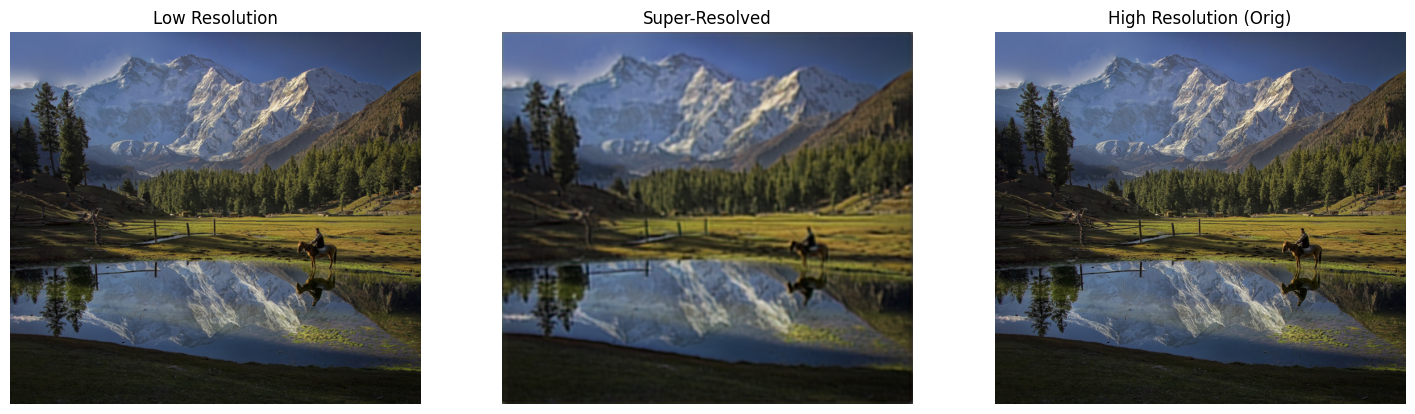

In [34]:
# Visualize output
test_img_id = 2
visualize_test_sample(model, transform, lr_path=f"../data/DIV2K/DIV2K_train_LR/X{scaling_factor}/000{test_img_id}.png", hr_path=f"../data/DIV2K/DIV2K_train_HR/000{test_img_id}.png")